In [9]:
import numpy as np
import pandas as pd
import datetime

In [16]:
water_original=pd.read_excel('demo/data/original_data.xls')

In [9]:
water_original.head()

,热水器编号,发生时间,开关机状态,加热中,保温中,有无水流,实际温度,热水量,水流量,节能模式,加热剩余时间,当前设置温度
0,R_00001,2014-10-19 06:39:17,关,关,关,无,30°C,0%,0,关,0分钟,50°C
1,R_00001,2014-10-19 07:01:54,关,关,关,无,30°C,0%,0,关,0分钟,50°C
2,R_00001,2014-10-19 07:01:56,关,关,关,无,30°C,0%,8,关,0分钟,50°C
3,R_00001,2014-10-19 07:12:30,关,关,关,无,30°C,0%,0,关,0分钟,50°C
4,R_00001,2014-10-19 07:12:36,关,关,关,无,29°C,0%,0,关,0分钟,50°C


In [17]:
#==============数据预处理===========
#使用pandas的to_datetime函数，直接将某一列字符串转化为日期型，无需使用apply匿名函数循环
water_original['发生时间']=pd.to_datetime(water_original['发生时间'],format='%Y%m%d%H%M%S')

In [18]:
water_original['节能模式'].unique()#全部为关，没有意义
water_original=water_original[['发生时间','开关机状态','加热中','保温中','实际温度','热水量','水流量','加热剩余时间','当前设置温度']]#有无水流和热水器编号删除
#pd.pivot_table(water_original,index=['开关机状态'],columns=['水流量'])

In [20]:
index=(water_original['开关机状态']=='关') & (water_original['水流量']==0)#两个条件表达式相连需要分别用括号括起来
water_original=water_original[-index]#热水器关且水流为零表示其不处于工作状态
water_original.head()

,发生时间,开关机状态,加热中,保温中,实际温度,热水量,水流量,加热剩余时间,当前设置温度
2,2014-10-19 07:01:56,关,关,关,30°C,0%,8,0分钟,50°C
56,2014-10-19 07:38:16,关,关,关,30°C,0%,8,0分钟,50°C
381,2014-10-19 09:46:38,关,关,关,29°C,0%,16,0分钟,50°C
382,2014-10-19 09:46:40,关,关,关,29°C,0%,13,0分钟,50°C
384,2014-10-19 09:47:15,关,关,关,29°C,0%,20,0分钟,50°C


In [25]:
water_original['发生时间'].describe()#2014.10.19-2014.11.10 共22天

count                   11432
unique                  11432
top       2014-11-08 08:48:11
freq                        1
first     2014-10-19 07:01:56
last      2014-11-10 23:20:00
Name: 发生时间, dtype: object

In [29]:
#=============划分同一事件===========
#根据经验指定阈值
threshhold=pd.Timedelta(minutes=5)#定义间隔时间阈值
devide=water_original.loc[water_original['水流量']>0]
#water_original['发生时间'].diff()#返回某一列相邻两个时间的间隔时间，第一个为空
d=devide['发生时间'].diff()>threshhold#与阈值比较，返回布尔型序列
devide['事件编号']=d.cumsum()+1#通过累计求和的方式为事件编号，布尔值True对应1，False对应0

E:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
devide.head()
devide.to_csv('demo/data/devide.csv',index=False)

In [3]:
devide=pd.read_csv('demo/data/devide.csv')
devide.head()

,发生时间,开关机状态,加热中,保温中,实际温度,热水量,水流量,加热剩余时间,当前设置温度,事件编号
0,2014-10-19 07:01:56,关,关,关,30°C,0%,8,0分钟,50°C,1
1,2014-10-19 07:38:16,关,关,关,30°C,0%,8,0分钟,50°C,2
2,2014-10-19 09:46:38,关,关,关,29°C,0%,16,0分钟,50°C,3
3,2014-10-19 09:46:40,关,关,关,29°C,0%,13,0分钟,50°C,3
4,2014-10-19 09:47:15,关,关,关,29°C,0%,20,0分钟,50°C,3


In [21]:
#根据不同阈值与所对应的事件个数分布情况，确定合适的阈值
#range不支持小数步长，np.arange可以；将结果数据存放到df时，先创建空df，然后用df.loc[df.shape[0]]指定特定位置上的值
threshold_df=pd.DataFrame(columns=('threshold','event_num'))
for i in np.arange(2,8.25,0.25):
    threshhold=pd.Timedelta(minutes=i)
    d=devide['发生时间'].diff()>threshhold
    threshold_df.loc[threshold_df.shape[0]]={'threshold':i,'event_num':d.sum()}
   

In [22]:
threshold_df.tail()

,threshold,event_num
20,7.00,157.0
21,7.25,157.0
22,7.50,154.0
23,7.75,153.0
24,8.00,152.0


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

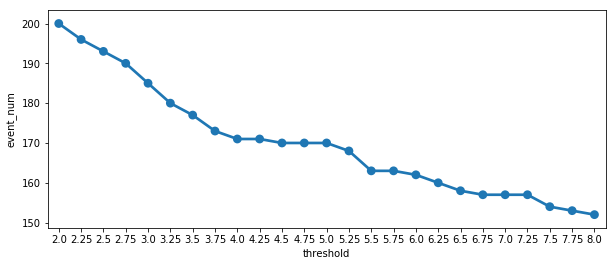

In [26]:
plt.figure(figsize=(10,4))
sns.pointplot(x='threshold',y='event_num',data=threshold_df)
#从图像上可以看出在阈值4-5区间，事件数量处于相对稳定状态，故选取阈值为4是合理的

In [32]:
#定量计算事件数斜率平均值
threshold_df['slop']=threshold_df['event_num'].diff()/0.25
threshold_df['slop_index']=pd.rolling_mean(threshold_df['slop'].abs(),4)
threshold_df

E:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  


,threshold,event_num,slop,slop_index
0,2.00,200.0,NaN,NaN
1,2.25,196.0,-16.0,NaN
2,2.50,193.0,-12.0,NaN
3,2.75,190.0,-12.0,NaN
4,3.00,185.0,-20.0,15.0
5,3.25,180.0,-20.0,16.0
6,3.50,177.0,-12.0,16.0
7,3.75,173.0,-16.0,17.0
8,4.00,171.0,-8.0,14.0
9,4.25,171.0,0.0,9.0


In [33]:
#rolling_mean自动计算前n个斜率的均值，最后需将结果向前平移n个单位
threshold_df['slop_index'].idxmin()-4

8

In [34]:
#===========生成训练和测试数据=====
#已经生成训练集和测试集
train=pd.read_excel('demo/data/train_neural_network_data.xls')#28条2014年的数据
test=pd.read_excel('demo/data/test_neural_network_data.xls')#21条2015年的数据

In [35]:
train.head()

,热水事件,起始数据编号,终止数据编号,开始时间（begin_time）,根据日志判断是否为洗浴（1表示是，0表示否）,洗浴时间点,总用水时长（w_time）,总停顿时长（w_pause_time）,平均停顿时长（avg_pause_time）,停顿次数（pause）,用水时长（use_water_time）,用水/总时长（use_water_rate）,总用水量（w_water）,平均水流量（water_rate）,水流量波动（flow_volatility）,停顿时长波动（pause_volatility）
0,1,218,344,2014-10-19 08:51:30',0,8,591.999998,303.500013,50.583336,6,288.499985,0.487331,12.998333,2.703293,0.870856,650.106848
1,2,569,965,2014-10-19 15:55:23',1,15,1008.000005,46.499999,46.499999,1,961.500006,0.953869,50.626667,3.159230,0.202300,0.000000
2,3,1077,1128,2014-10-19 18:21:40',0,18,467.999997,269.499987,53.899997,5,198.500010,0.424145,7.087500,2.142317,0.404960,531.384976
3,4,1973,2236,2014-10-20 16:42:41',1,16,660.999996,23.499993,23.499993,1,637.500003,0.964448,32.193333,3.029961,0.291306,0.000000
4,5,2320,2435,2014-10-20 18:05:28',1,18,550.000005,164.500013,32.900003,5,385.499992,0.700909,13.459167,2.094812,0.395200,180.384977
